This is a notebook meant to display the results of the MCMC run that Tom ran during late Jan / early Feb 2018. It differs from the previous run because it includes S. Wampfler's APEX 3-2, 4-3 data.

Tom varied X_in, X_out, T_jump, with each smoothly varying.

A lot of this comes from these docs:
https://github.com/dfm/emcee/blob/master/docs/tutorials/monitor.rst


# Part 1: the MCMC results.

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
print(emcee.__version__)
reader = emcee.backends.HDFBackend("../model_chain_wampf.h5")

3.0.0.dev0


In [165]:
tau = reader.get_autocorr_time(quiet=True)
burnin = int(2*np.max(tau))
# burnin=0
thin=1
# thin = int(0.5*np.min(tau))
all_samples = reader.get_chain(discard=0, thin=1)

samples = reader.get_chain(discard=burnin, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("chain shape: {0}".format(all_samples.shape))
# print("flat log prob shape: {0}".format(log_prob_samples.shape))
# print("flat log prior shape: {0}".format(log_prior_samples.shape))
print("Mean acceptance fraction: {0:.3f}"
      .format(np.mean(np.mean(reader.accepted / all_samples.shape[0]))))


burn-in: 69
thin: 1
chain shape: (1776, 24, 3)
Mean acceptance fraction: 0.633


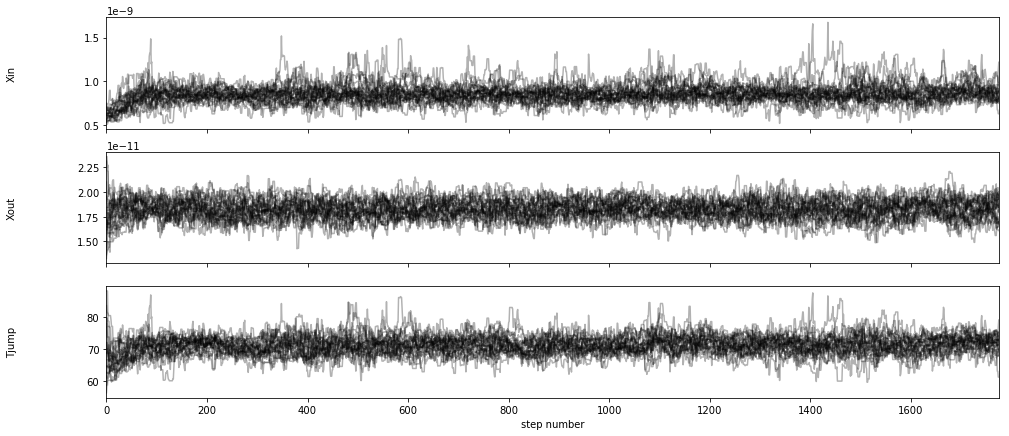

In [166]:
fig, axes = plt.subplots(all_samples.ndim, figsize=(16, 7), sharex=True)
labels = ["Xin", "Xout", "Tjump"]
for i in range(all_samples.ndim):
    ax = axes[i]
    ax.plot(all_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(all_samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

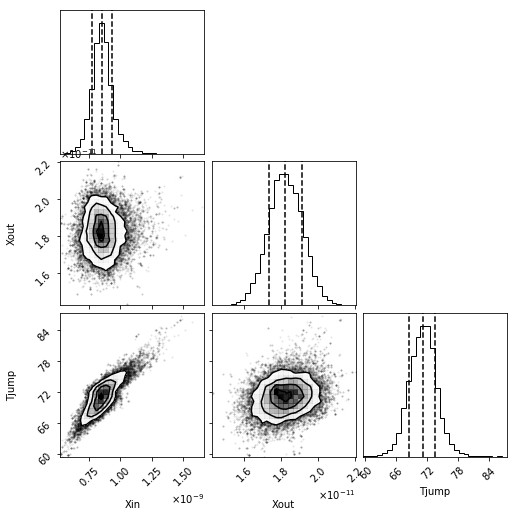

In [175]:
flat_samples = reader.get_chain(discard=burnin, flat=True, thin=1)
fig_corner = corner.corner(flat_samples, labels=labels, use_math_text=True, quantiles=[0.16,0.50,0.84], bins=30)

plt.show()

In [168]:
from IPython.display import display, Math

for i in range(samples.ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    
    numbers = [mcmc[1], q[0], q[1]]
    exponent = np.floor(np.log10(np.abs(mcmc[1])))
    significands = [x/10**exponent for x in numbers]
    
    if np.abs(exponent) > 3:

        txt = "\mathrm{{{4}}} = \\left( {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}} \\right) \\times 10^{{{3:2d}}}"
        txt = txt.format(*significands, int(exponent), labels[i])
    else:
        txt = "\mathrm{{{3}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    print(txt)
    display(Math(txt))

\mathrm{Xin} = \left( 8.51_{-0.74}^{+0.81} \right) \times 10^{-10}


<IPython.core.display.Math object>

\mathrm{Xout} = \left( 1.82_{-0.09}^{+0.09} \right) \times 10^{-11}


<IPython.core.display.Math object>

\mathrm{Tjump} = 71.2_{-2.6}^{+2.4}


<IPython.core.display.Math object>

In [169]:
# Now let's derive the HCN abundance. From the h13cn abundance.

# Ratio and uncertainty from Wilson 1999
C_1213_ratio = 69 
C_1213_error = 6

for i in range(samples.ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    
    if i < 2:
#         numbers = [mcmc[1], q[0], q[1]]
        h13cn_value, h13cn_positive_error, h13cn_negative_error = [mcmc[1], q[0], q[1]]
        print(numbers)
        
        hcn_value = h13cn_value*69
        print("HCN abundance value: {:.2e}".format(hcn_value))
        
        # Error propagation here assumes Gaussian uncertainties. 
        # It's an approximation (and not horrible if you look at the distributions above.)
        
        variance_hcn_pos = hcn_value**2 * ( (C_1213_error/C_1213_ratio)**2 + (h13cn_positive_error/h13cn_value)**2 )
        sigma_hcn_pos = variance_hcn_pos**(1/2)

        variance_hcn_neg = hcn_value**2 * ( (C_1213_error/C_1213_ratio)**2 + (h13cn_negative_error/h13cn_value)**2 )
        sigma_hcn_neg = variance_hcn_neg**(1/2)

        print("HCN positive error: {:.2e}".format(sigma_hcn_pos))
        print("HCN negative error: {:.2e}".format(sigma_hcn_neg))

        numbers = [hcn_value, sigma_hcn_neg, sigma_hcn_pos]
        exponent = np.floor(np.log10(np.abs(hcn_value)))
        significands = [x/10**exponent for x in numbers]

        txt = "\mathrm{{{4}}} = \\left( {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}} \\right) \\times 10^{{{3:2d}}}"
        txt = txt.format(*significands, int(exponent), labels[i])
        print(txt)
        display(Math(txt))
        
        

[71.172332740180536, 2.6243603469444139, 2.43961516397286]
HCN abundance value: 5.87e-08
HCN positive error: 7.24e-09
HCN negative error: 7.55e-09
\mathrm{Xin} = \left( 5.87_{-0.76}^{+0.72} \right) \times 10^{-8}


<IPython.core.display.Math object>

[5.871433974259326e-08, 7.5544385637968012e-09, 7.2408673536038589e-09]
HCN abundance value: 1.26e-09
HCN positive error: 1.26e-10
HCN negative error: 1.27e-10
\mathrm{Xout} = \left( 1.26_{-0.13}^{+0.13} \right) \times 10^{-9}


<IPython.core.display.Math object>

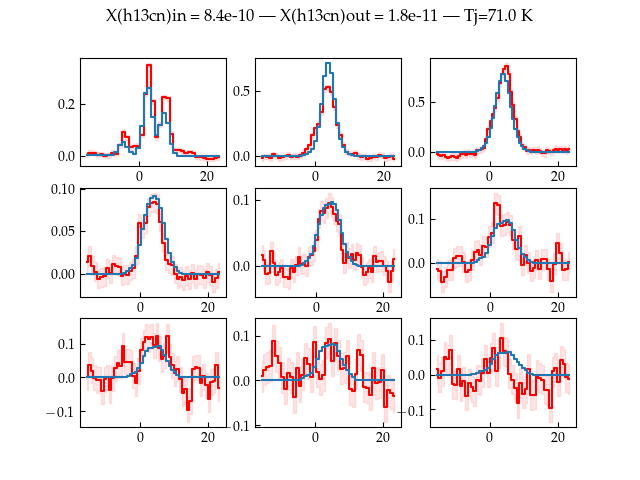

In [56]:
from IPython.display import Image
Image(filename='bestfit.png')

# Part 2: Compiling N/H2O numbers.

In [8]:
bestfit_h13cn_Xin = 8.66e-10
bestfit_h13cn_Xout = 1.95e-11

# Assume standard 12C/13C isotopic ratio.
HCN_Xin = 69 * bestfit_h13cn_Xin
HCN_Xout = 69 * bestfit_h13cn_Xout

print("X(HCN) in: {:.3e}".format(HCN_Xin))
print("X(HCN) out: {:.3e}".format(HCN_Xout))

X(HCN) in: 5.975e-08
X(HCN) out: 1.345e-09


In [25]:
# Results from Coutens+12.
H2O_Xin = 5e-6
H2O_Xout = 1.5e-8

HCN_H2O_in = HCN_Xin / H2O_Xin
HCN_H2O_out = HCN_Xout / H2O_Xout
HCN_H2O_mid = HCN_Xin / H2O_Xout

print("HCN/H2O inner: {:.3f}".format(HCN_H2O_in))
print("HCN/H2O outer: {:.3f}".format(HCN_H2O_out))
print("HCN/H2O mid: {:.2f}".format(HCN_H2O_mid))


HCN/H2O inner: 0.012
HCN/H2O outer: 0.090
HCN/H2O mid: 3.98


In [10]:
water_jump = H2O_Xin/H2O_Xout
HCN_jump = HCN_Xin/HCN_Xout
print(water_jump)
print(HCN_jump)

333.33333333333337
44.410256410256416


In [295]:
# In Orion KL
HCN_Xorionkl = 6.4e-7 # From Crockett et al 2014
H2O_Xorionkl = 6.5e-4 # From Neill et al 2013b, actually

HCN_H2O_orionkl = HCN_Xorionkl / H2O_Xorionkl
print("HCN/H2O Orion KL: {:.4f}".format(HCN_H2O_orionkl))

NH3_Xorionkl_min = 8e-7
NH3_Xorionkl_max = 6e-6

min_NH3_H2O_orionkl = NH3_Xorionkl_min / H2O_Xorionkl
max_NH3_H2O_orionkl = NH3_Xorionkl_max / H2O_Xorionkl

print("NH3/H2O Orion KL: {:.4f}--{:.4f}".format(min_NH3_H2O_orionkl, max_NH3_H2O_orionkl))


HCN/H2O Orion KL: 0.0010
NH3/H2O Orion KL: 0.0012--0.0092


In [305]:
# In comets, from Mumma & Charnley 2011
HCN_H2O_comets = 0.2 * 1/100
NH3_H2O_comets = 0.6 * 1/100
HNCO_H2O_comets = 0.04 * 1/100
HNC_H2O_comets = 0.01 * 1/100
print("HCN/H2O in comets: {:.4f}".format(HCN_H2O_comets))
print("NH3/H2O in comets: {:.4f}".format(NH3_H2O_comets))

volatile_N_H2O_comets = sum([HCN_H2O_comets, NH3_H2O_comets, HNCO_H2O_comets, HNC_H2O_comets])
print("volatile N/H2O in comets: {:.4f}".format(volatile_N_H2O_comets))

organic_N_H2O_comets = sum([HCN_H2O_comets, HNCO_H2O_comets, HNC_H2O_comets])
print("organic N/H2O in comets: {:.4f}".format(organic_N_H2O_comets))


HCN/H2O in comets: 0.0020
NH3/H2O in comets: 0.0060
volatile N/H2O in comets: 0.0085
organic N/H2O in comets: 0.0025


In [24]:
# Wyckoff et al (1991) reports that 90% of Comet Halley's N is in dust. So let's scale up.

total_N_H2O_comets = volatile_N_H2O_comets * 10
print("HCN/H2O in comets:                  {:.3f}".format(HCN_H2O_comets))
print("NH3/H2O in comets:                  {:.3f}".format(NH3_H2O_comets))
print("total N/H2O in comets (incl. dust): {:.3f}".format(total_N_H2O_comets))
print("")
print("HCN/H2O, Orion KL Hot Core:         {:.4f}".format(HCN_H2O_orionkl))
print("Organic N/H2O, Orion KL Hot Core:   {:.4f}".format(HCN_H2O_orionkl/0.74))
print("")
print("HCN/H2O, inner envelope IRAS 16293: {:.3f}".format(HCN_H2O_in))
print("HCN/H2O, outer envelope IRAS 16293: {:.3f}".format(HCN_H2O_out))

HCN/H2O in comets:                  0.002
NH3/H2O in comets:                  0.006
total N/H2O in comets (incl. dust): 0.085

HCN/H2O, Orion KL Hot Core:         0.0010
Organic N/H2O, Orion KL Hot Core:   0.0013

HCN/H2O, inner envelope IRAS 16293: 0.012
HCN/H2O, outer envelope IRAS 16293: 0.090


In [101]:
np.mean(reader.accepted / all_samples.shape[0])

0.63550884955752218

In [56]:
emcee.autocorr.integrated_time?

# 3. An experiment with calculating and displaying "3-sigma" (99.7% confidence) error bars.

In [171]:
from IPython.display import display, Math

for i in range(samples.ndim):
    print("Three sigma errorbars")
    mcmc = np.percentile(flat_samples[:, i], [0.135, 50, 99.865])
    q = np.diff(mcmc)
    
    numbers = [mcmc[1], q[0], q[1]]
    exponent = np.floor(np.log10(np.abs(mcmc[1])))
    significands = [x/10**exponent for x in numbers]
    
    if np.abs(exponent) > 3:

        txt = "\mathrm{{{4}}} = \\left( {0:.2f}_{{-{1:.2f}}}^{{+{2:.2f}}} \\right) \\times 10^{{{3:2d}}}"
        txt = txt.format(*significands, int(exponent), labels[i])
    else:
        txt = "\mathrm{{{3}}} = {0:.1f}_{{-{1:.1f}}}^{{+{2:.1f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    print(txt)
    display(Math(txt))

Three sigma errorbars
\mathrm{Xin} = \left( 8.51_{-2.69}^{+4.58} \right) \times 10^{-10}


<IPython.core.display.Math object>

Three sigma errorbars
\mathrm{Xout} = \left( 1.82_{-0.28}^{+0.29} \right) \times 10^{-11}


<IPython.core.display.Math object>

Three sigma errorbars
\mathrm{Tjump} = 71.2_{-9.6}^{+11.6}


<IPython.core.display.Math object>

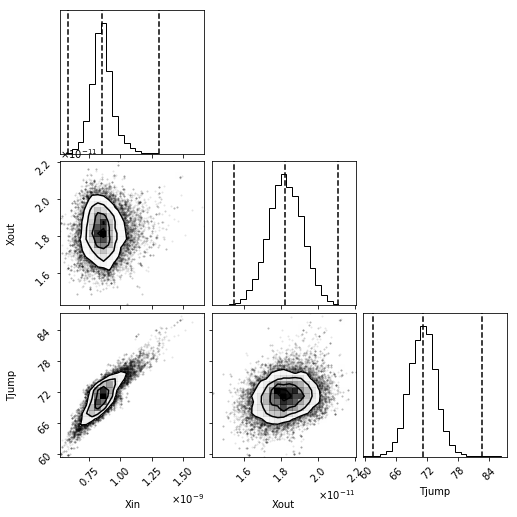

In [172]:
flat_samples = reader.get_chain(discard=burnin, flat=True, thin=1)
fig_corner = corner.corner(flat_samples, labels=labels, use_math_text=True, quantiles=[0.00135, 0.50, 0.99865], bins=25)

plt.show()